In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!unzip "/content/drive/MyDrive/Colab Notebooks/dataset.zip" -d "/content/drive/MyDrive/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/dataset/Training/notumor/Tr-no_1020.jpg  
  inflating: /content/drive/MyDrive/dataset/Training/notumor/Tr-no_0458.jpg  
  inflating: /content/drive/MyDrive/dataset/Training/notumor/Tr-no_0504.jpg  
  inflating: /content/drive/MyDrive/dataset/Training/notumor/Tr-no_0262.jpg  
  inflating: /content/drive/MyDrive/dataset/Training/notumor/Tr-no_0276.jpg  
  inflating: /content/drive/MyDrive/dataset/Training/notumor/Tr-no_1168.jpg  
  inflating: /content/drive/MyDrive/dataset/Training/notumor/Tr-no_0510.jpg  
  inflating: /content/drive/MyDrive/dataset/Training/notumor/Tr-no_0538.jpg  
  inflating: /content/drive/MyDrive/dataset/Training/notumor/Tr-no_1140.jpg  
  inflating: /content/drive/MyDrive/dataset/Training/notumor/Tr-no_1154.jpg  
  inflating: /content/drive/MyDrive/dataset/Training/notumor/Tr-no_1183.jpg  
  inflating: /content/drive/MyDrive/dataset/Training/notumor/Tr-no_1197.jpg  
  inflating: 

In [12]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

In [13]:
train_data_path = "/content/drive/MyDrive/dataset/Training"

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds :
    f_path = os.path.join(train_data_path, fold)
    if os.path.isdir(f_path):
        filelists = os.listdir(f_path)

        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(fold)

#concat data paths with labels
Fseries = pd.Series(filepaths, name = "filepaths")
Lseries = pd.Series(labels, name = "label")
train_df = pd.concat([Fseries, Lseries], axis =1)

In [14]:
test_data_path = "/content/drive/MyDrive/dataset/Testing"

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds :
    f_path = os.path.join(test_data_path, fold)
    if os.path.isdir(f_path):
        filelists = os.listdir(f_path)

        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(fold)

#concat data paths with labels
Fseries = pd.Series(filepaths, name = "filepaths")
Lseries = pd.Series(labels, name = "label")
test_df = pd.concat([Fseries, Lseries], axis =1)

#Data Spliting

In [15]:
valid, test = train_test_split(test_df, train_size = 0.5, shuffle = True, random_state = 42)

In [16]:
img_size = (224 ,224)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size=batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


#Show Images and Labels

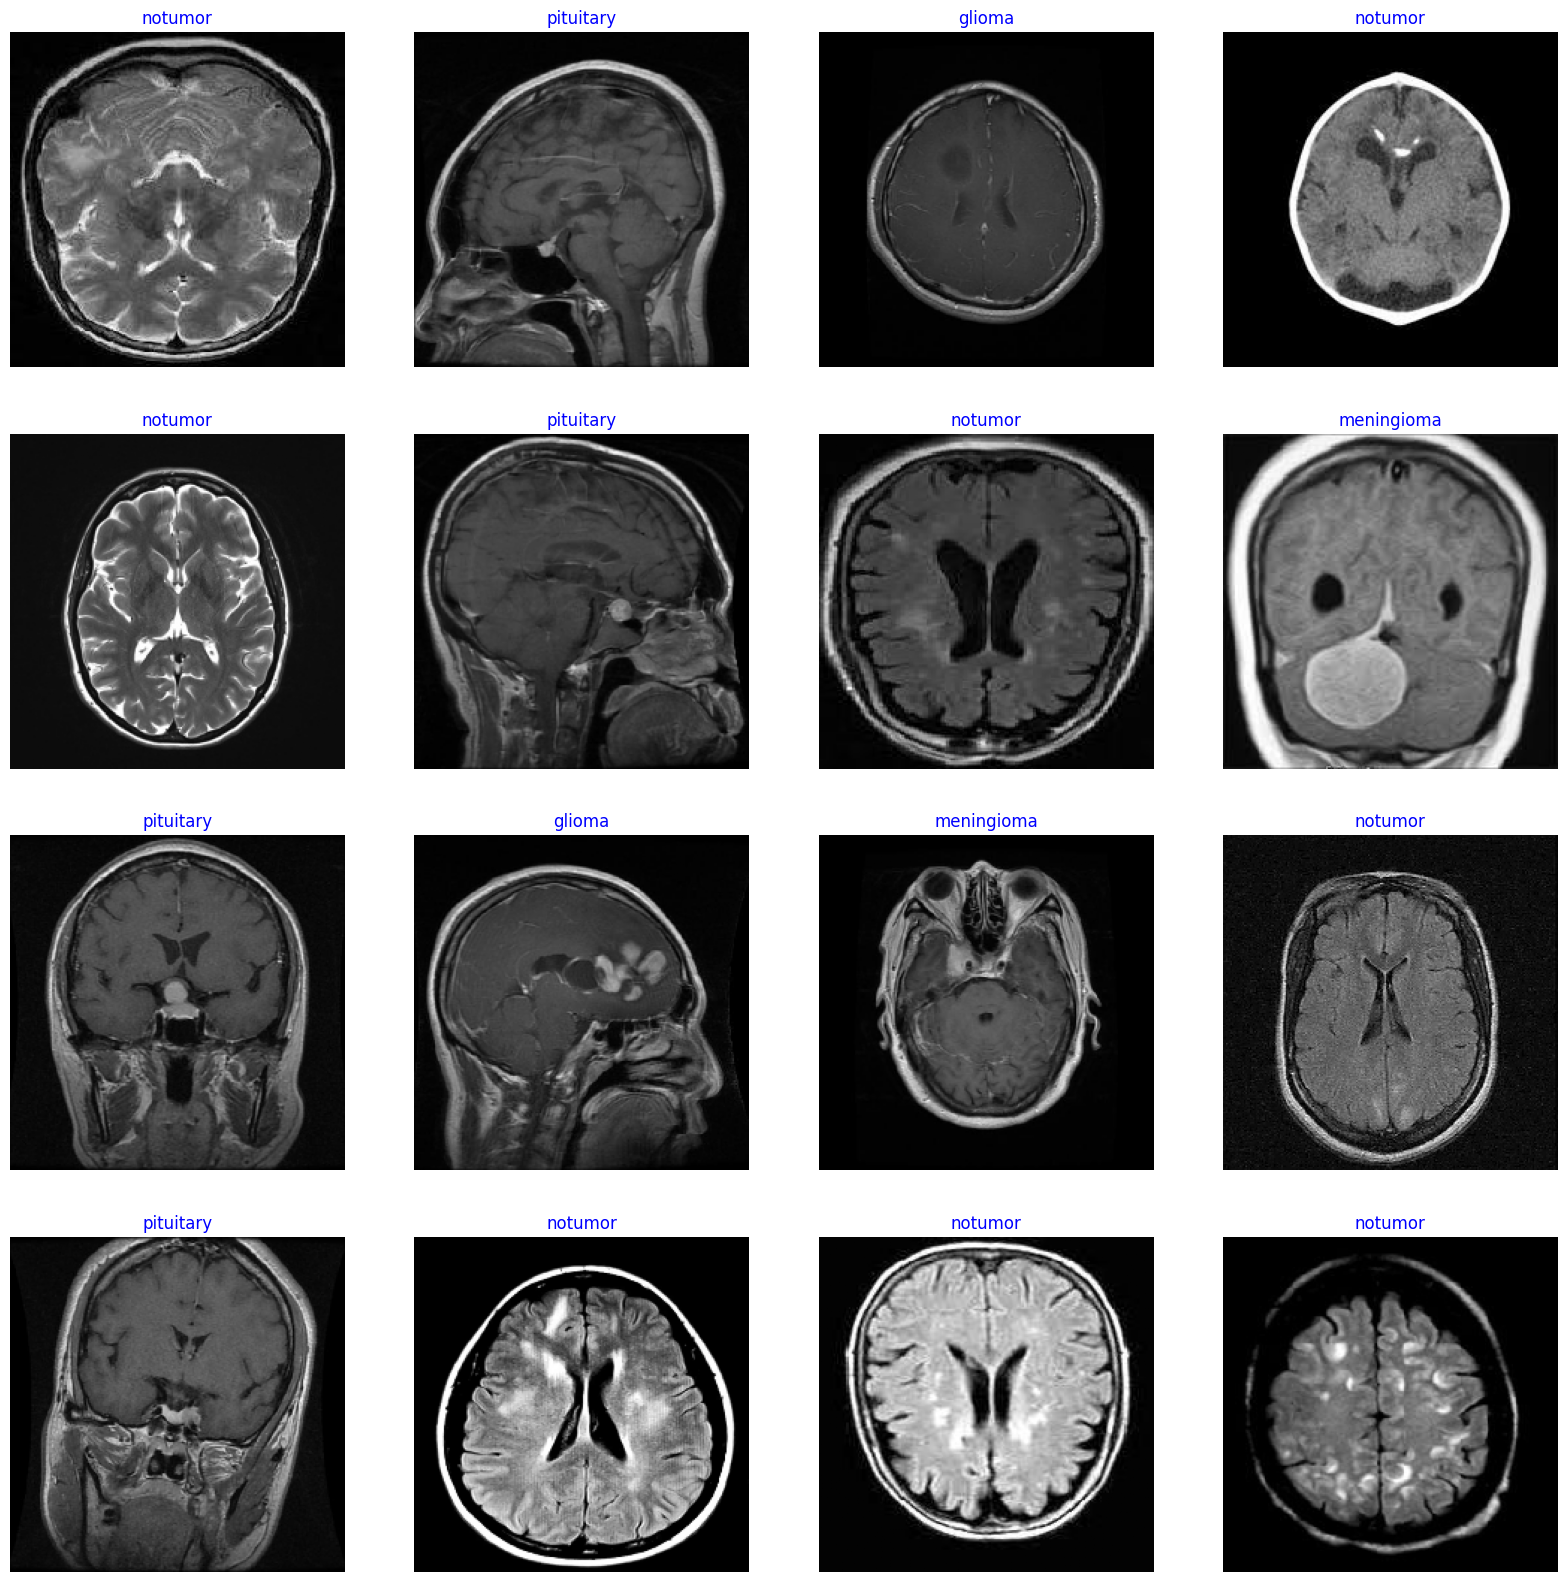

In [17]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize = (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color = "blue", fontsize = 12)
    plt.axis("off")
plt.show();

#Building Model Layer

In [18]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top = False , weights = 'imagenet',
    input_shape = img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,253,396 (23.85 MB)

 Trainable params: 6,190,228 (23.61 MB)

 Non-trainable params: 63,168 (246.75 KB)

#Training Model

In [19]:
Epochs = 1

history = model.fit(
    train_gen,
    epochs=Epochs,
    verbose=1,
    validation_data=valid_gen,
    shuffle=True
)

357/357 ━━━━━━━━━━━━━━━━━━━━ 147s 151ms/step - accuracy: 0.5619 - loss: 10.7423 - val_accuracy: 0.3527 - val_loss: 5.4509


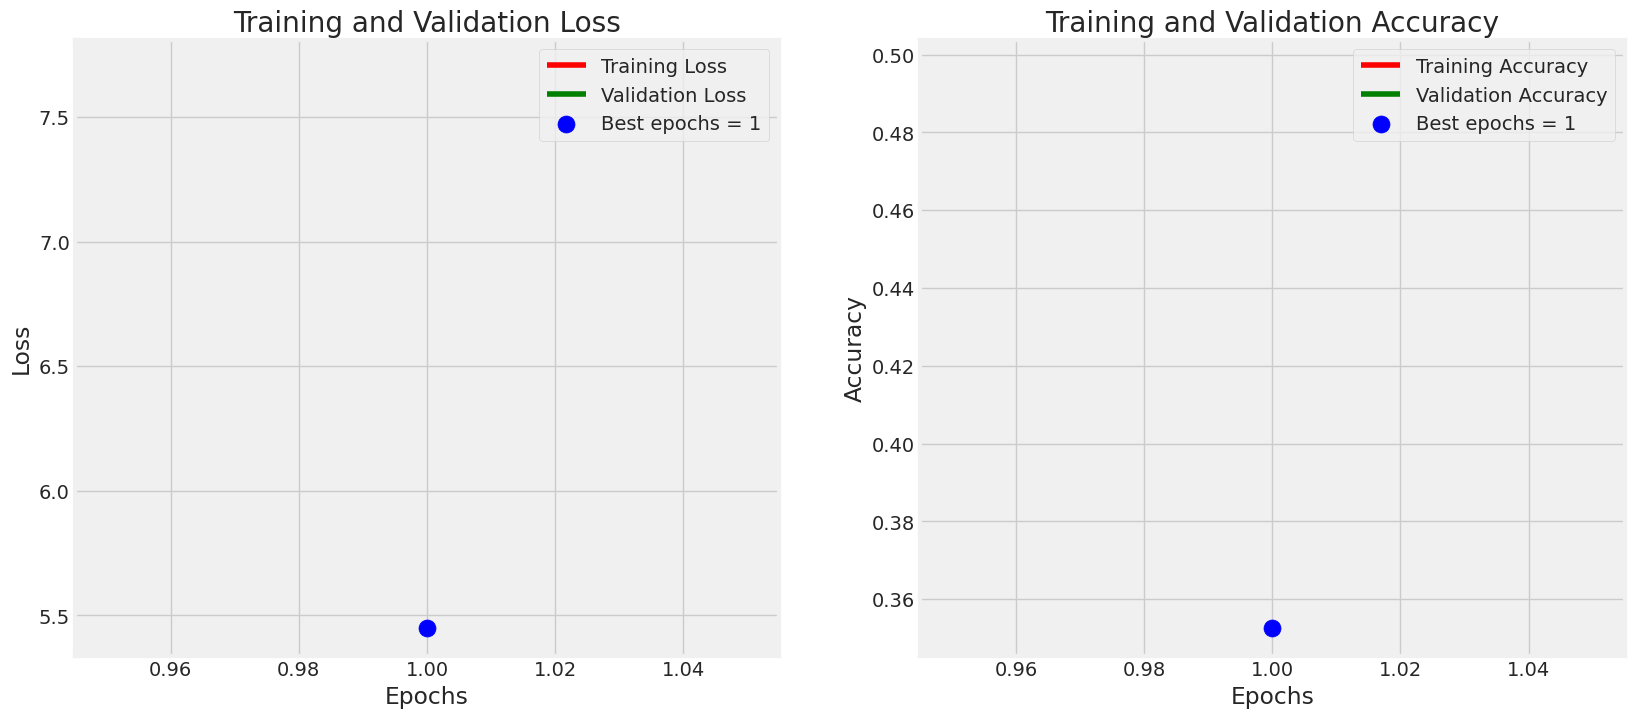

In [20]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [21]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ",test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.4045 - loss: 5.4484
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.3449 - loss: 5.4616
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.3483 - loss: 5.4457
Train Loss:  5.440840244293213
Train Accuracy:  0.37109375
--------------------
Validation Loss:  5.452346324920654
Validation Accuracy:  0.33984375
--------------------
Test Loss:  5.445761203765869
Test Accuracy:  0.33984375


In [22]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds,axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step


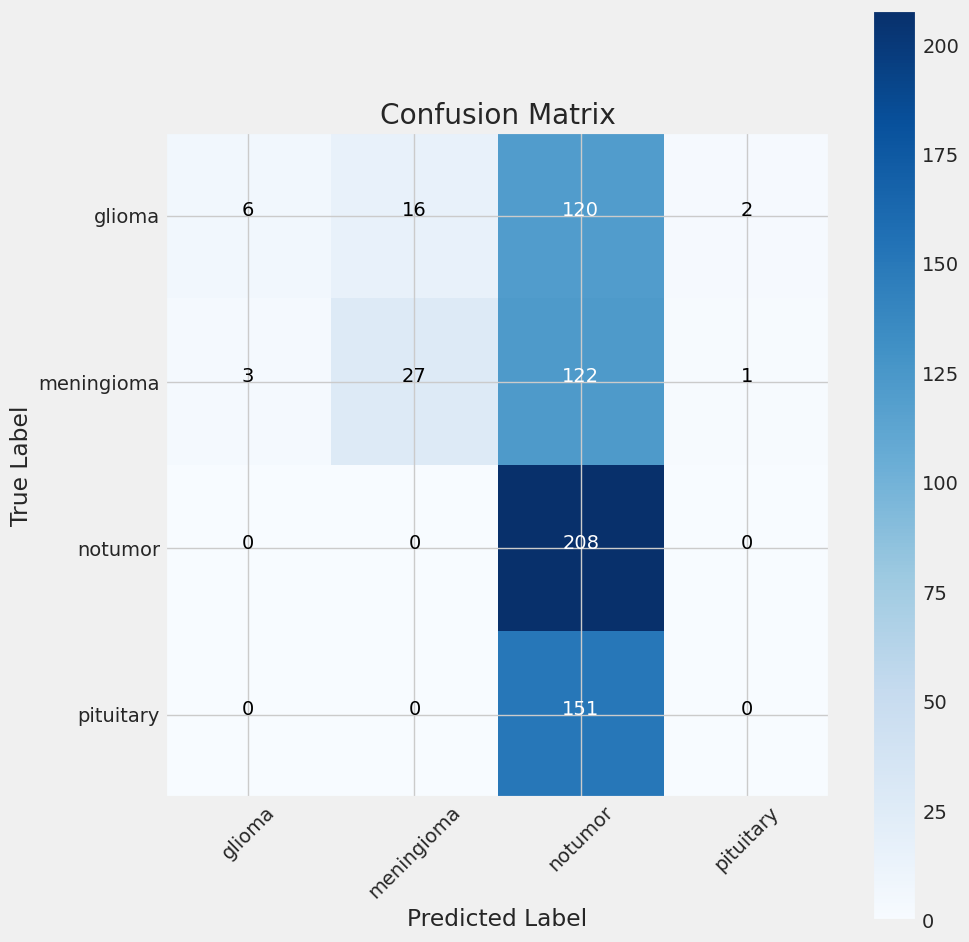

In [23]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

#Classification Report


In [24]:
print(classification_report(test_gen.classes, y_pred , target_names=classes))

              precision    recall  f1-score   support

      glioma       0.67      0.04      0.08       144
  meningioma       0.63      0.18      0.28       153
     notumor       0.35      1.00      0.51       208
   pituitary       0.00      0.00      0.00       151

    accuracy                           0.37       656
   macro avg       0.41      0.30      0.22       656
weighted avg       0.40      0.37      0.24       656



#Load Model

In [25]:
model.save("model.h5")

In [26]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

In [27]:
model = load_model('model.h5', compile=False)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [28]:
gambar = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/dataset/Testing/glioma/Te-glTr_0000.jpg', target_size=img_size)

In [29]:
input_arr = tf.keras.preprocessing.image.img_to_array(gambar)

In [30]:
input_arr = np.array([input_arr])
prediksi = model.predict(input_arr)
predicted_class = np.argmax(prediksi,axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


In [31]:
print(predicted_class)

[2]


In [32]:
print(classes)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [33]:
names = [classes[i] for i in predicted_class]
print(names)

['notumor']
